In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns


sns.set_theme(context="poster", style="ticks",
              palette="Set2", color_codes=True)


from astropy import units as u
from astropy. io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

from pyFIT3D.common.constants import __c__
from pyFIT3D.common.tools import get_wave_from_header

from neighborhood_analogs.constants import CURRENT_RUN_VERSION
from neighborhood_analogs.constants import NAMES, NAMES_MAP, COLORS, UNITS_MAP, FIELD_LATEX, FIELD_NAMES, RE_MW, R_SUN
from neighborhood_analogs.constants import CALIFA_DATA_PATH, CALIFA_CATALOGUE_PATH, CALIFA_MORPHOLOGY_PATH, CALIFA_AGN_PATH, CALIFA_VCOR_PATH, MASTAR_DATA_PATH
from neighborhood_analogs.constants import CALIFA_SCALE, HUBBLE_CLASSIFICATION, FITTING_WINDOW, OBS_CUBE_FMT, RGB_WAVELENGTHS, RGB_HW
from neighborhood_analogs.constants import SNA_MAP_NAMES
from neighborhood_analogs._cmdline.find_analogs import create_RGB, load_catalogues, load_mastar_data, filter_general
from neighborhood_analogs.common import TABLE_MW, categorical_mode_sdev, format_name, parse_table_st, parse_types_range
from neighborhood_analogs.common import ellipse, find_distance
from neighborhood_analogs.plotting import sna_hist, projected_circle

In [2]:
sna_wl, sna_sed, sigma_dist, mastar_catalogue = load_mastar_data(path=MASTAR_DATA_PATH, return_catalogue=True, verbose=True)

mastar_coords = SkyCoord(ra=mastar_catalogue.RA, dec=mastar_catalogue.DEC, distance=mastar_catalogue.DIST*u.kpc)
mastar_R = mastar_coords.galactic.distance.value * np.cos(mastar_coords.galactic.l.value*np.pi/180) + 8


sigma_dist = 1.24 kpc


In [3]:
# load and filter catalogue
catalogue_full = load_catalogues(
    catalogue_path=CALIFA_CATALOGUE_PATH,
    morph_path=CALIFA_MORPHOLOGY_PATH,
    agn_path=CALIFA_AGN_PATH,
    vcor_path=CALIFA_VCOR_PATH,
    hubble_map=HUBBLE_CLASSIFICATION,
    verbose=False
)
catalogue = filter_general(catalogue=catalogue_full, verbose=False)

In [4]:
# read filtered model cube
current_run_path = f"../_data/out_{CURRENT_RUN_VERSION}"

names_ext, sna_tables = [], []
for name, row in tqdm(catalogue.iterrows(), total=len(catalogue), desc="listing SNA hosts", ascii=True, unit="galaxy"):
    # read SNA spaxel table
    try:
        sna_table = Table(fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 1, header=False)).to_pandas()
    except FileNotFoundError:
        continue
    if len(sna_table) != 0:
        names_ext.append(name)
        sna_table["name"] = name
        sna_tables.append(sna_table)
sna_table = pd.concat(sna_tables, axis="index", ignore_index=True)

listing SNA hosts: 100%|##########| 330/330 [00:01<00:00, 192.96galaxy/s]


analyzing SNAs: 100%|##########| 61/61 [00:05<00:00, 10.20galaxy/s]


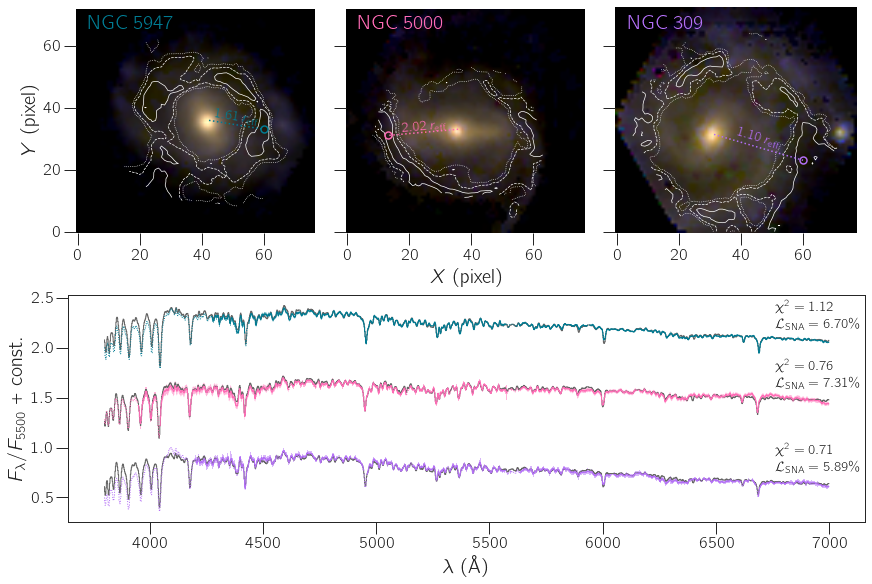

In [5]:
b_window = (RGB_WAVELENGTHS[0]-RGB_HW, RGB_WAVELENGTHS[0]+RGB_HW)
g_window = (RGB_WAVELENGTHS[1]-RGB_HW, RGB_WAVELENGTHS[1]+RGB_HW)
r_window = (RGB_WAVELENGTHS[2]-RGB_HW, RGB_WAVELENGTHS[2]+RGB_HW)
par_names = [key.split()[0] for key in SNA_MAP_NAMES.keys()]
# repeated_idx = 8
# par_names[repeated_idx] = par_names[repeated_idx]+"_px" if par_names[repeated_idx]=="Sigma_mass" else par_names[repeated_idx]

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, :])
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)
ax2.set_xlabel(r"$X$ (pixel)")
ax1.set_ylabel(r"$Y$ (pixel)")

ax4.set_xlabel(r"$\lambda$ (\AA)")
ax4.set_ylabel(r"$F_\lambda/F_{5500}$ + const.")

axs = [ax1, ax2, ax3, ax4]
sna_spaxel_gr = sna_table.groupby("name")
catalogue[par_names + ["x_sna", "y_sna"]] = np.nan
for i, (name, row) in tqdm(enumerate(catalogue.loc[names_ext].iterrows()), total=len(names_ext), desc="analyzing SNAs", ascii=True, unit="galaxy"):
    # read filtered properties
    par_cube_rs = fits.getdata(f"{current_run_path}/{name}_par.cube.filtered.fits.gz")
    # read likelihood map
    lik_cube = fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 0, header=False)
    # extract relevent maps
    mod_map = lik_cube[1]
    snr_map = lik_cube[2]
    nor_map = lik_cube[3]
    chi_map = lik_cube[4]
    lik_map = lik_cube[5]
    bad_map = lik_cube[6].astype(int).astype(bool)
    # mask chi and likelihood maps
    total_mask = bad_map | (chi_map < 0) | (snr_map <= 40) | (mod_map <= 0.)
    chi_map[total_mask] = np.nan
    lik_map[total_mask] = np.nan

    # likelihood normalized by sum (volume) this is the likelihood of each pixel being a SNA relative to other pixels in the galaxy
    # some cases: if the galaxy has no pixel with likelihood above zero, then the galaxy has zero probability of hosting a SNA
    #             otherwise, the galaxy will have a 100 percent chance of hosting a SNA
    lik_map = np.divide(lik_map, np.nansum(lik_map), where=np.nansum(lik_map)!=0, out=lik_map) * 100
    # likelihood normalized by fraction of pixels having a likelihood above zero is the likelihood of each pixel being a SNA relative to other galaxies
    # some cases: this likelihood can be compared between different galaxies
    # lik_map = lik_map / np.nanmax(lik_map)
    # lik_map = lik_map * (np.nansum(lik_map[~total_mask]>0)/(~total_mask).sum()) * 100

    # locate region with highest likelihood of being SNA
    x_sna, y_sna = sna_spaxel_gr.get_group(name)[["x", "y"]].values.T
    max_idx = np.argmin(chi_map[y_sna, x_sna])
    x, y = x_sna[max_idx], y_sna[max_idx]
    catalogue.loc[name, par_names] = par_cube_rs[:, y, x]
    catalogue.loc[name, ["x_sna", "y_sna"]] = x, y
    catalogue.loc[name, "r_sna"] = find_distance(1.0, row.re_arc, x, y, row.xc, row.yc, row.pa, row.ellipticity, CALIFA_SCALE)

    # display the RBG and the likelihood maps (highlighting the pixels of the spectra above)
    if name in NAMES:
        j = NAMES.index(name)

        # read obs cube
        obs_cube = fits.getdata(os.path.join(CALIFA_DATA_PATH, OBS_CUBE_FMT.format(name)))
        # obs_cube = fits.getdata(os.path.join("../_data/cache", OBS_CUBE_FMT.format(name)))
        err_cube_rs = fits.getdata(f"{current_run_path}/{name}_err.cube.filtered.fits.gz")
        # read model cube
        mod_cube_rs, mod_header = fits.getdata(f"{current_run_path}/{name}_mod.cube.filtered.fits.gz", 0, header=True)
        wl = get_wave_from_header(header=mod_header, wave_axis=3)
        wl_mask = (FITTING_WINDOW[0] <= wl) & (wl <= FITTING_WINDOW[1])

        # compute galaxy physical scale
        galaxy_scale = row.re_arc / row.re_kpc
        # compute voxel radius using galaxy scale
        voxel_radius = int(np.floor(sigma_dist * galaxy_scale / CALIFA_SCALE))

        # read SNA cube
        sna_cube = fits.getdata(f"{current_run_path}/{name}_sna.cube.fits.gz", 0)

        rgb_image = rgb_image = create_RGB(
            cube=obs_cube,
            wavelength=wl,
            R_filt=(6200,6700),
            G_filt=(5100,5650),
            B_filt=(3770,3900)
        )
        pixels_x, pixels_y = np.arange(
            lik_map.shape[1], dtype=int), np.arange(lik_map.shape[0], dtype=int)
        X, Y = np.meshgrid(pixels_x, pixels_y)

        lik_mask = np.sqrt( (X-x)**2 + (Y-y)**2 ) <= voxel_radius

        axs[j].imshow(rgb_image, origin="lower", interpolation="bilinear")
        cn = axs[j].contour(lik_map/np.nanmax(lik_map), levels=(0.01, 0.05, 0.32), colors="w", linestyles=(":", "--", "-"), linewidths=0.7)
        axs[j].plot([row.xc, x], [row.yc, y], ":", lw=1.5, color=COLORS[j])
        axs[j].plot(x, y, marker="o", ms=7, mew=1.5, mfc="none", mec=COLORS[j])
        axs[j].text(
            (row.xc+x)/2, (row.yc+y)/2, r"$%.2f\,r_\mathrm{eff}$"%(catalogue.loc[name].r_sna),
            ha="center", rotation=np.arctan((y-row.yc)/(x-row.xc))*180/np.pi, color=COLORS[j], size="xx-small"
        )
        axs[j].text(0.05, 0.9, f"{format_name(name)}", color=COLORS[j], size="small", transform=axs[j].transAxes)
        sns.despine(ax=axs[j], bottom=True, left=True)

        # display 3 example spectra and the corresponding likelihood of being a SNA
        y_offset = 0.7*2-0.7*j
        wl_ = wl[wl_mask]
        mod_spectrum = mod_cube_rs[wl_mask, y, x]
        sna_spectrum = sna_cube[wl_mask, y, x] * nor_map[y, x]
        err_spectrum = np.nan_to_num(err_cube_rs[wl_mask, y, x], nan=np.nan, posinf=np.nan, neginf=np.nan)
        nan_mask = np.isnan(err_spectrum)
        renorm = mod_spectrum.max()
        mod_spectrum /= renorm
        sna_spectrum /= renorm

        axs[3].fill_between(wl_, (mod_spectrum-err_spectrum)+y_offset, (mod_spectrum+err_spectrum)+y_offset, step="pre", lw=0, fc=COLORS[j], alpha=0.5)
        axs[3].step(wl_, sna_spectrum+y_offset, lw=1, color="0.4")

        axs[3].step(wl_, np.ma.masked_where(nan_mask,mod_spectrum)+y_offset, lw=1, color=COLORS[j])
        axs[3].step(wl_, np.ma.masked_where(~nan_mask,mod_spectrum)+y_offset, ":", lw=1, color=COLORS[j])

        axs[3].text(wl_[-120], sna_spectrum[-1]+y_offset+0.1, r"$\mathcal{L}_\mathrm{SNA}=%.2f\%%$" % np.nansum(lik_map[lik_mask]), va="bottom", ha="left", size="xx-small")
        axs[3].text(wl_[-120], sna_spectrum[-1]+y_offset+0.27, r"$\chi^2=%.2f$" % chi_map[y, x], va="bottom", ha="left", size="xx-small")

fig.savefig("_img_letter/sna-showcase.pdf", bbox_inches="tight")

In [6]:
hubble_types = pd.Series(pd.Categorical(HUBBLE_CLASSIFICATION, ordered=True))

table_sna = catalogue.loc[names_ext]
table_sna["type"] = table_sna.type.str[0] + table_sna.bar.apply(lambda b: "B" if b else "").str[0:1] + table_sna.type.str[1:]
table_sna = table_sna.drop(columns=["bar"])
# table_sna.index = table_sna.index.str.replace("NED01", "A").str.replace("NED02", "B")
# table_sna["M/L"] = np.log10(table_sna["M/L"])
table_sna = table_sna.filter(items=FIELD_NAMES).rename(columns=NAMES_MAP)


In [7]:
# set hubble types as a category and sort by Hubble classification
types_sna = table_sna.Type.str.replace("B", "").astype("category").cat.set_categories(HUBBLE_CLASSIFICATION).cat.as_ordered().value_counts().sort_index()
types_sna = types_sna.reset_index().rename(columns={"index":"Type", "Type":"counts"})
# assign an integer to each category
type_mode, type_sdev = categorical_mode_sdev(types_sna.counts.values)
types_range = types_sna.loc[type_mode-type_sdev:type_mode+type_sdev, "Type"]

# parse table in latex format
table_sna_st = table_sna.drop(columns="Type").aggregate("median std".split(), axis="index")
table_sna_ch = parse_table_st(table_sna_st, mu_name="median")
table_sna_ch["Type"] = parse_types_range(types_range, barredness="(B)")

# --------------------------------------------------------------------------------------------------------------------
type_mode, type_sdev = TABLE_MW["Type"].astype(int)
types_range = hubble_types[type_mode-type_sdev:type_mode+type_sdev]

table_mw_ch = parse_table_st(TABLE_MW.drop(columns=["Type"]))
table_mw_ch["Type"] = parse_types_range(types_range, barredness="(B)")
table_mw_ch.name = "MW"
# --------------------------------------------------------------------------------------------------------------------

table_letter = pd.concat((table_mw_ch, table_sna_ch), axis="columns").rename(index=NAMES_MAP, columns={0:"SNA"}).reindex(FIELD_LATEX)
table_letter
# print(table_letter.style.to_latex())

MW  \
Type                                                S(B)b~--~bc   
$\log{M_\star/\textrm{M}_\odot}$                 $10.70\pm0.09$   
$\log{\psi_\star}$                                $0.22\pm0.05$   
$r_\mathrm{eff}$                                  $4.20\pm0.40$   
$\left<\log{t/\textrm{yr}}\right>_{L_\star}$      $9.38\pm0.09$   
$\left<\log{t/\textrm{yr}}\right>_{M_\star}$      $9.70\pm0.22$   
$\left<[Z/\textrm{Z}_{\odot}]\right>_{L_\star}$  $-0.08\pm0.18$   
$\left<[Z/\textrm{Z}_{\odot}]\right>_{M_\star}$  $-0.06\pm0.20$   
$A_V$                                             $0.19\pm0.02$   
$\left<\log{M_\star/L_\star}\right>$              $0.36\pm0.04$   
$\log{\Sigma_{M_\star}}$                          $1.76\pm0.07$   
$\log{\Sigma_{\psi_\star}}$                      $-8.24\pm0.09$   
$r_\mathrm{SNA}/r_\mathrm{eff}$                   $1.95\pm0.19$   

                                                            SNA  
Type                                                 S(B)a~--~c  
$\log{M_\star/\textrm{M}_\odot}$                 $10.95\pm0.26$  
$\log{\psi_\star}$                                $0.41\pm0.43$  
$r_\mathrm{eff}$                                  $5.18\pm3.32$  
$\left<\log{t/\textrm{yr}}\right>_{L_\star}$      $9.10\pm0.17$  
$\left<\log{t/\textrm{yr}}\right>_{M_\star}$      $9.76\pm0.14$  
$\left<[Z/\textrm{Z}_{\odot}]\right>_{L_\star}$  $-0.20\pm0.09$  
$\left<[Z/\textrm{Z}_{\odot}]\right>_{M_\star}$  $-0.17\pm0.14$  
$A_V$                                             $0.15\pm0.25$  
$\left<\log{M_\star/L_\star}\right>$              $0.60\pm0.12$  
$\log{\Sigma_{M_\star}}$                          $1.85\pm0.27$  
$\log{\Sigma_{\psi_\star}}$                      $-8.44\pm0.50$  
$r_\mathrm{SNA}/r_\mathrm{eff}$                   $2.11\pm1.63$

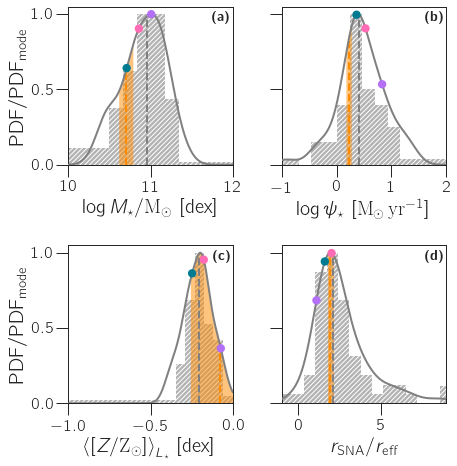

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=True)

for abc, ax, name in zip("abcd", axs.ravel(), "mass_star sfr_star Z_L r_sna".split()):
    sna_hist(NAMES_MAP[name], data_sna=table_sna, data_mw=TABLE_MW, ax=ax, units=UNITS_MAP[name], ex_names=NAMES, ex_colors=COLORS, ex_type="dot")
    ax.text(0.99, 0.97, r"\textbf{(%s)}"%abc, size="xx-small", va="top", ha="right", transform=ax.transAxes)

fig.tight_layout()
plt.savefig("_img_letter/sna-pars.pdf", bbox_inches="tight")

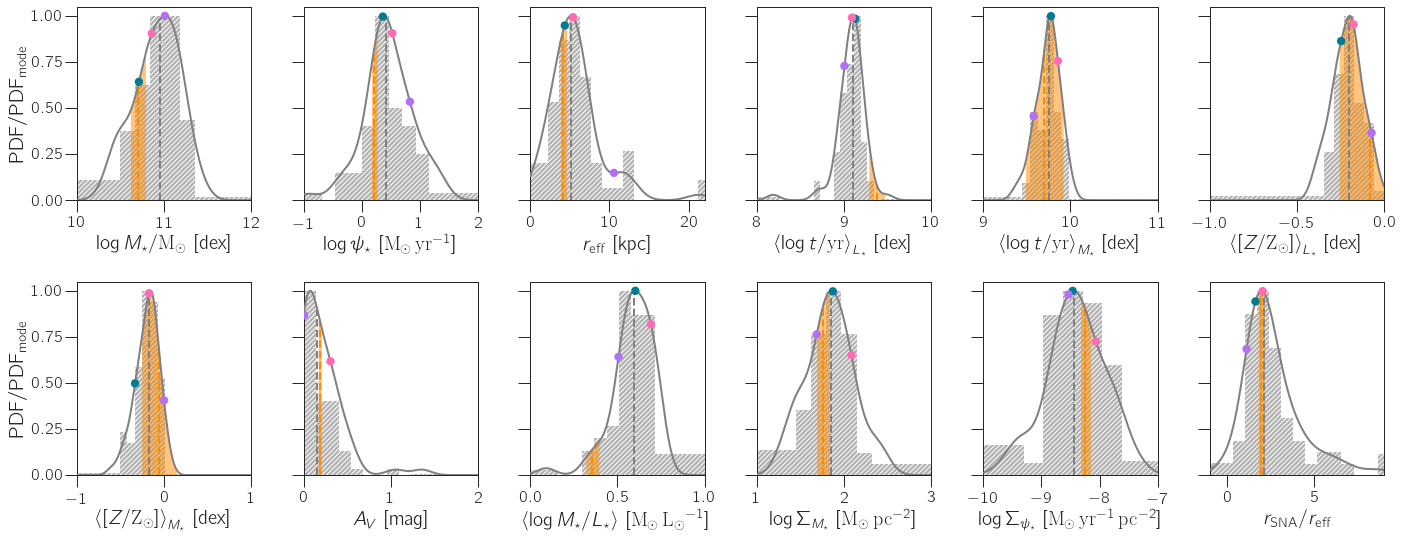

In [9]:
par_dist_names = [name for name in FIELD_NAMES if name not in ["type"]]

fig, axs = plt.subplots(2, len(par_dist_names)//2, figsize=(20,8), sharex=False, sharey=True)

for ax, name in zip(axs.ravel(), par_dist_names):
    sna_hist(NAMES_MAP[name], data_sna=table_sna, data_mw=TABLE_MW, ax=ax, units=UNITS_MAP[name], ex_names=NAMES, ex_colors=COLORS, ex_type="dot")

fig.tight_layout()